In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [8]:
# Define the ticker symbols for assets in the portfolio
ticker_symbols = ['AAPL', 'GOOG', 'MSFT', 'TSLA']

# Fetch historical stock data using yfinance
stock_data = yf.download(ticker_symbols, start='2020-01-01', end='2021-01-01')

# Calculate daily returns for each asset
daily_returns = stock_data['Adj Close'].pct_change().dropna()


[*********************100%%**********************]  4 of 4 completed


In [9]:
# Calculate mean returns and covariance matrix
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

# Number of assets
num_assets = len(ticker_symbols)

# Define risk-free rate (e.g., 10-year Treasury yield)
risk_free_rate = 0.04  # Example risk-free rate as decimal


In [10]:
# Objective function to minimize negative Sharpe ratio
def negative_sharpe_ratio(weights):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return -sharpe_ratio

# Constraints: weights sum up to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for portfolio weights (0 <= weights <= 1)
bounds = tuple((0, 1) for _ in range(num_assets))

# Initial guess for portfolio weights
initial_weights = np.ones(num_assets) / num_assets

# Minimize negative Sharpe ratio to find tangent portfolio (optimal risky portfolio)
result = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
tangent_portfolio_weights = result.x

# Calculate portfolio return and standard deviation for tangent portfolio
tangent_portfolio_return = np.sum(mean_returns * tangent_portfolio_weights)
tangent_portfolio_std_dev = np.sqrt(np.dot(tangent_portfolio_weights.T, np.dot(cov_matrix, tangent_portfolio_weights)))

# Calculate slope of capital allocation line (CAL)
cal_slope = (tangent_portfolio_return - risk_free_rate) / tangent_portfolio_std_dev

# Calculate weights for the risk-free asset and the risky portfolio
risk_free_weight = (cal_slope / tangent_portfolio_std_dev**2) * (tangent_portfolio_return - risk_free_rate)
risky_weight = 1 - risk_free_weight

In [11]:
cal_slope

-0.5328090855137287

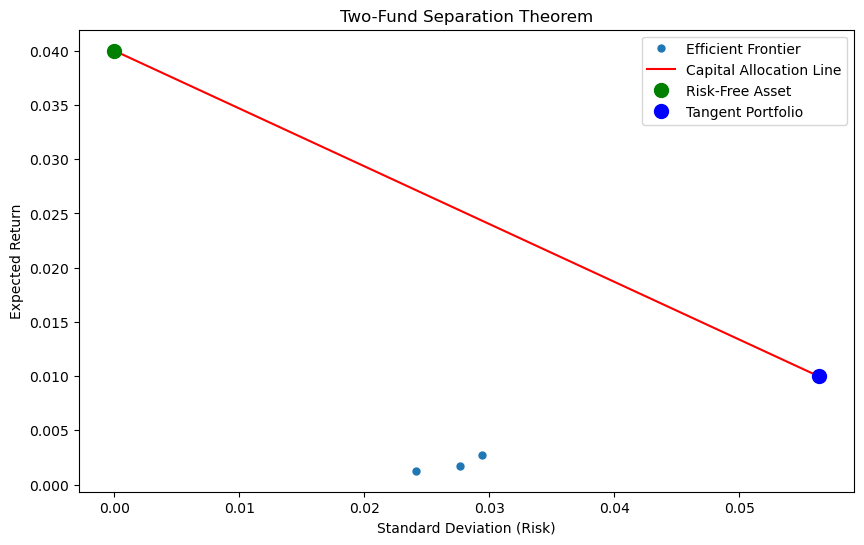

In [12]:
# Plot the efficient frontier, CAL, and risk-free asset
fig, ax = plt.subplots(figsize=(10, 6))

# Plot efficient frontier
ax.plot(np.sqrt(np.diag(cov_matrix)), mean_returns, 'o', markersize=5, label='Efficient Frontier')

# Plot CAL
ax.plot([0, tangent_portfolio_std_dev], [risk_free_rate, tangent_portfolio_return], linestyle='-', color='red', label='Capital Allocation Line')

# Plot risk-free asset
ax.plot(0, risk_free_rate, 'o', color='green', markersize=10, label='Risk-Free Asset')

# Plot tangent portfolio
ax.plot(tangent_portfolio_std_dev, tangent_portfolio_return, 'o', color='blue', markersize=10, label='Tangent Portfolio')

# Set labels and title
ax.set_xlabel('Standard Deviation (Risk)')
ax.set_ylabel('Expected Return')
ax.set_title('Two-Fund Separation Theorem')

# Add legend
ax.legend()

plt.show()